In [1]:
# # This mounts your Google Drive to the Colab VM.
# from google.colab import drive
# drive.mount('/content/drive')
#
# # TODO: Enter the foldername in your Drive where you have saved the unzipped
# # assignment folder, e.g. 'dl/assignments/assignment3/'
# FOLDERNAME = "dl/assignments/assignment3/"
# assert FOLDERNAME is not None, "[!] Enter the foldername."
#
# # Now that we've mounted your Drive, this ensures that
# # the Python interpreter of the Colab VM can load
# # python files from within it.
# import sys
# sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# Denoising Diffusion Probabilistic Models

So far, we have explored discriminative models, which are trained to produce a labeled output. These range from straightforward image classification to sentence generation where the problem was still framed as classification, with labels in vocabulary space and a recurrence mechanism capturing multi-word labels. Now, we will expand our repertoire by building a generative model capable of creating novel images that resemble a given set of training images.

There are many types of generative models, including Generative Adversarial Networks (GANs), autoregressive models, normalizing flow models, and Variational Autoencoders (VAEs), all of which can synthesize striking images. However, in 2020, Ho et al. introduced Denoising Diffusion Probabilistic Models (DDPMs) by combining diffusion probabilistic models with denoising score matching. This resulted in a generative model that is both simple to train and powerful enough to generate complex, high-quality images. The following provides a high-level overview of DDPMs. For more details, please refer to the course slides and the original DDPM paper [1].


# Forward Process
Let $q(x_0)$ be the distribution of clean dataset images. We define a forward noising process as a Markov chain of small noising steps:

$$q(x_t | x_{t-1}) \sim N(x_t; \sqrt{1-\beta_t} x_{t-1} , \beta_t I)$$

where the stepwise variance $(\beta_1, ..., \beta_T)$ determines the noise schedule. Due to the properties of Gaussian distributions, we can express $q(x_t | x_0)$ in closed form as:

$$q(x_t | x_0) \sim N(x_t; \sqrt{\bar{\alpha}_t} x_0 , (1-\bar{\alpha}_t) I)$$

where $\alpha_t = 1-\beta_t$ and $\bar{\alpha}_t = \prod_{s=1}^{t}\alpha_t$.
If the noise schedule $(\beta_1, ..., \beta_T)$ is set properly, the final distribution $q(x_T)$ becomes indistinguishable from pure Gaussian noise $N(0, I)$.

Recall that sampling from a Gaussian distribution $x \sim N(\mu, \sigma^2)$ is equivalent to computing $\sigma * \epsilon + \mu$ where $\epsilon \sim N(0, 1)$. Hence, sampling from $q(x_t | x_{t-1})$ or $q(x_t | x_0)$ is straightforward given $x_{t-1}$ or $x_0$ respectively. Because of this, the forward process is simple and does not require learning.

# Reverse Process
The reverse process reconstructs a clean image $x_0$ from pure noise $x_T$ through multiple steps. Let $p(x_{t-1} | x_t)$ denote the reverse step of $q(x_t | x_{t-1})$.
The first key insight is that learning to reverse each individual denoising step is easier than reversing the entire forward process in one go. In other words, learning $p(x_{t-1} | x_t)$ for each $t$ is easier than directly learning $p(x_0 | x_T)$.

However, learning $p(x_{t-1} | x_t)$ is still challenging. Although $q(x_t | x_{t-1})$ is Gaussian, $p(x_{t-1} | x_t)$ could take any complex form and is almost certainly not Gaussian. Modeling and sampling from an arbitrary distribution is significantly harder than working with a simple parametric distribution like a Gaussian.

The second key insight is that if the stepwise noise $\beta_t$ in the forward process is small enough, then the reverse step $p(x_{t-1} | x_t)$ is also close to a Gaussian distribution. Thus, we only need to estimate its mean and variance. In practice, setting the variance of $p(x_{t-1} | x_t)$ to match $\beta_t$ (the same as in the forward step) works well. Consequently, learning the reverse process reduces to learning the mean $\mu(x_t, t; \theta)$ where $\theta$ represents the parameters of a neural network.

# Denoising Objective
Generative models are optimized by minimizing the expected negative log-likelihood $\mathbb{E}[-\log{p_\theta(x_0)}]$ of the dataset samples. The likelihood of each sample can be expressed as: $p_\theta(x_0) = p(x_T)\prod_{t=1}^T p(x_{t-1} | x_t)$. Since this objective is intractable in many cases, various classes of generative models optimize the variational lower bound on the negative log-likelihood.

Ho et al. demonstrated that this objective is equivalent to minimizing the following denoising loss

$$\mathbb{E}_{t, x_0, \epsilon}\left[ \| \epsilon - \epsilon_\theta (\sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon, t ) \|^2 \right]$$

where $t$ is uniform between 1 and T, $x_0$ is clean sample, $\epsilon$ is sampled from standard gaussian $N(0, I)$, and $\epsilon_\theta$ is a neural network model trained to predict the noise $\epsilon$ from the input noisy sample $x_t = \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$. In other words, $\epsilon_\theta$ learns to denoise the input noisy image. Note that this is equivalent to predicting the clean sample, since the noise can be recovered from the noisy image and the clean sample following the equation $x_t = \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$.


[1] Denoising Diffusion Probabilistic Models. Jonathan Ho, Ajay Jain, Pieter Abbeel. [Link](https://arxiv.org/pdf/2006.11239)



# In This Notebook...
We will implement and train a DDPM model to generate small 32 x 32 emoji images conditioned on text prompts. First, we will implement the forward noising process based on Eq. (4) of the paper [1]. Then we will build a UNet model that takes $x_t$ and $t$ as inputs (optionally with other conditioning like text-prompt) and outputs a tensor of the same shape as $x_t$. Finally, we will implement the denoising objective and train our DDPM model.

We use the text encoder from a pretrained CLIP[2] model to encode input text into a 512-dimensional vector. To speed up training, we've already pre-encoded the text data from the training set.

[2] Learning transferable visual models from natural language supervision. Radford et. al. [Link](https://github.com/openai/CLIP)

In [2]:
!pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to /private/var/folders/r8/rh5fqj8j73j3j5g6_ssjqk4h0000gn/T/pip-req-build-zvgvnllu
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/r8/rh5fqj8j73j3j5g6_ssjqk4h0000gn/T/pip-req-build-zvgvnllu
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [3]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import torchvision.utils as tv_utils
from dl.emoji_dataset import EmojiDataset
from dl.gaussian_diffusion import GaussianDiffusion

def rel_error(x, y):
    """Returns relative error."""
    return np.max(np.abs(x - y) / (np.maximum(1e-10, np.abs(x) + np.abs(y))))

def force_deterministic_weights(model):
    """
    Overwrites model weights with a fixed, deterministic pattern.
    This ensures tests pass regardless of RNG state or initialization order.
    """
    with torch.no_grad():
        for i, param in enumerate(model.parameters()):
            # Generate a pattern: sin(layer_index + element_index) * 0.1
            # This creates distinct, non-zero values for every weight
            flattened_indices = torch.arange(param.numel()).to(param.device).float()
            pattern = torch.sin(i + flattened_indices).reshape(param.shape)
            param.copy_(pattern * 0.1)

/Users/samuelbenibgui/Desktop/Master/DL/DiffusionModel/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# First, let's load and visualize the dataset.
# Each sample of the dataset is a tuple: (image, {"text_emb": <tensor>, "text": <string>})
# We will use a pretrained text-encoder to encode text into an embedding vector.
# We have pre-encoded the dataset texts into embeddings for faster training.
image_size = 32
dataset = EmojiDataset(image_size)


emoji_data.npz already downloaded.
text_embeddings.pt already downloaded.


One sample: (image: [3, 32, 32], { "text_emb": [512], "text": string })


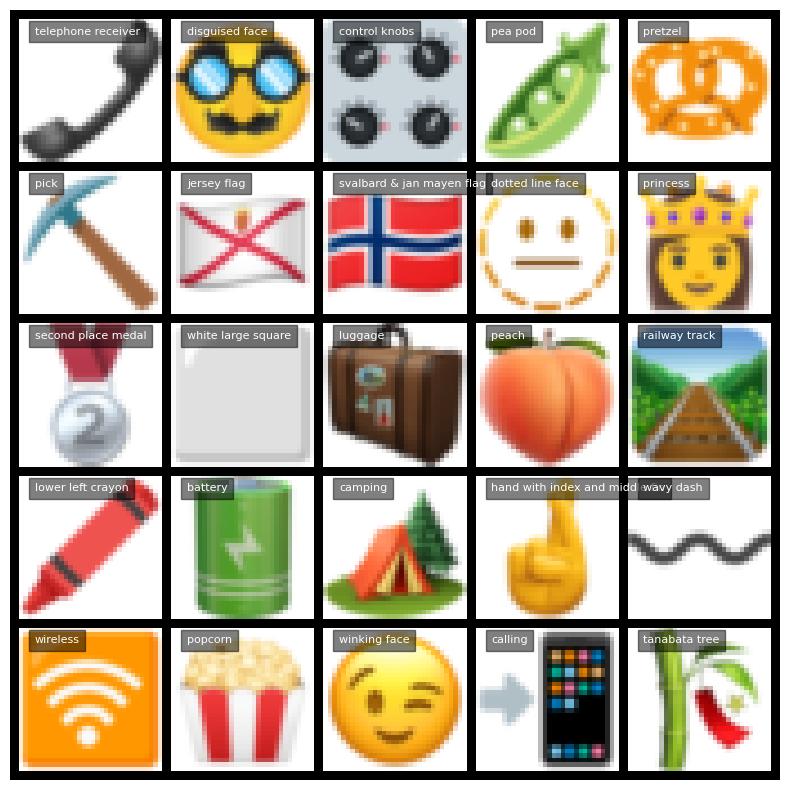

In [5]:
def visualize_samples(dataset, num_samples=25, grid_size=(5, 5)):
    # Randomly sample indices
    indices = random.sample(range(len(dataset)), num_samples)
    samples = [dataset[i] for i in indices]

    # Inspect one sample
    img_shape = list(samples[0][0].shape)
    emb_shape = list(samples[0][1]["text_emb"].shape)
    print(f"One sample: (image: {img_shape}, {{ \"text_emb\": {emb_shape}, \"text\": string }})")

    # Extract images and texts
    images = torch.stack([sample[0] for sample in samples])  # Stack images
    texts = [sample[1]["text"] for sample in samples]  # Extract text descriptions

    # Create a grid of images
    grid_img = tv_utils.make_grid(images, nrow=grid_size[1], padding=2)

    # Convert to numpy for plotting
    grid_img = grid_img.permute(1, 2, 0).numpy()

    # Plot the images
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(grid_img)
    ax.axis("off")

    # Add text annotations
    grid_w, grid_h = grid_size
    img_w, img_h = grid_img.shape[1] // grid_w, grid_img.shape[0] // grid_h

    for i, text in enumerate(texts):
        row, col = divmod(i, grid_w)
        x, y = col * img_w, row * img_h
        ax.text(x+5, y+5, text[:30], fontsize=8, color='white', bbox=dict(facecolor='black', alpha=0.5))

    plt.show()

visualize_samples(dataset)

## q_sample

Now we will define the forward noising process. Read through the GaussianDiffusion class in `dl/gaussian_diffusion.py`. Consult the original DDPM paper[1] for the equations. Implement `q_sample` method and test it below. You should see zero relative error.

In [6]:
# Test GaussianDiffusion.q_sample method
sz = 2
b = 3

diffusion = GaussianDiffusion(
      model=None,
      image_size=sz,
      timesteps=1000,
      beta_schedule="sigmoid",
)

t = torch.tensor([0, 300, 999]).long()
x_start = torch.linspace(-0.9, 0.6, b*3*sz*sz).view(b, 3, sz, sz)
noise = torch.linspace(-0.7, 0.8, b*3*sz*sz).view(b, 3, sz, sz)
x_t = diffusion.q_sample(x_start, t, noise)

expected_x_t = np.array([
    [
        [[-0.9119949, -0.86840147], [-0.8248081, -0.7812148]],
        [[-0.7376214, -0.694028], [-0.65043473, -0.6068413]],
        [[-0.563248, -0.51965463], [-0.47606122, -0.43246788]],
    ],
    [
        [[-0.42800453, -0.37039882], [-0.31279305, -0.2551873]],
        [[-0.19758154, -0.1399758], [-0.08237009, -0.024764337]],
        [[0.032841414, 0.090447165], [0.14805292, 0.20565866]],
    ],
    [
        [[0.32864183, 0.37152246], [0.41440308, 0.45728368]],
        [[0.50016433, 0.5430449], [0.5859255, 0.6288062]],
        [[0.67168677, 0.7145674], [0.757448, 0.8003287]],
    ],
]).astype(np.float32)

# Should see zero relative error
print("x_t error: ", rel_error(x_t.numpy(), expected_x_t))

x_t error:  0.0


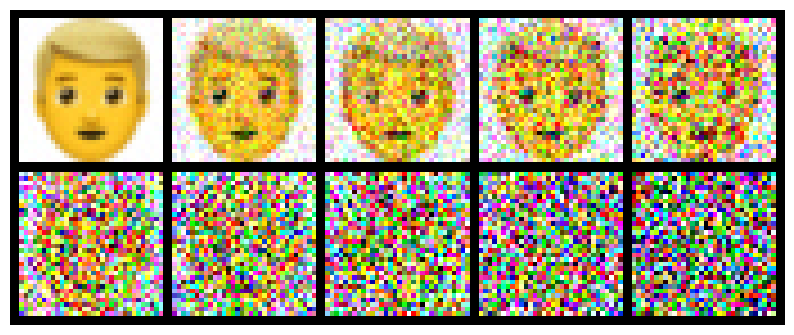

In [7]:
# Let's visualize the noisy images at various timesteps.
diffusion = GaussianDiffusion(
      model=None,
      image_size=image_size,
      timesteps=1000,
)

B = 10
img = dataset[770][0]  # 3 x H x W
x_start = img[None].repeat(B, 1, 1, 1)  # B x 3 x H x W
noise = torch.randn_like(x_start)  # B x 3 x H x W
t = torch.linspace(0, 1000-1, B).long()

x_start = diffusion.normalize(x_start)
x_t = diffusion.q_sample(x_start, t, noise)
x_t = diffusion.unnormalize(x_t).clamp(0, 1)
grid_img = tv_utils.make_grid(x_t, nrow=5, padding=2)
grid_img = grid_img.permute(1, 2, 0).cpu().numpy()
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(grid_img)
ax.axis("off")
plt.show()

A diffusion model can be trained to predict either the clean image or the noise, as one can be derived from the other (explained in 'Denoising Objective' section above). Implement `predict_start_from_noise` and `predict_noise_from_start` methods and test them below. You should see relative error less than 1e-5.

In [8]:
# Test `predict_noise_from_start` and `predict_start_from_noise`
sz = 2
b = 3

diffusion = GaussianDiffusion(
      model=None,
      image_size=sz,
      timesteps=1000,
      beta_schedule="sigmoid",
)

t = torch.tensor([1, 300, 998]).long()
x_start = torch.linspace(-0.91, 0.67, b*3*sz*sz).view(b, 3, sz, sz)
noise = torch.linspace(-0.73, 0.81, b*3*sz*sz).view(b, 3, sz, sz)
x_t = diffusion.q_sample(x_start, t, noise)

pred_noise = diffusion.predict_noise_from_start(x_t, t, x_start)
pred_x_start = diffusion.predict_start_from_noise(x_t, t, noise)

# Should relative errors around 1e-5 or less
print("noise error: ", rel_error(pred_noise.numpy(), noise.numpy()))
print("x_start error: ", rel_error(pred_x_start.numpy(), x_start.numpy()))

noise error:  1.0600407e-06
x_start error:  1.8902663e-06


## UNet Model

Now that we have defined the forward process, let's define the UNet model for denoising the input image. UNet is a neural network architecture designed for image-to-image tasks like segmentation, style transfer, etc. It consists of an encoder (or downsampling module) that transforms the input image into hierarchical features with decreasing spatial resolution and increasing feature dimensions. The decoder (or upsampling module) then upsamples the features by progressively restoring the spatial resolution, mirroring the encoder's structure. At each decoder layer, features from the corresponding encoder layer are concatenated, providing a direct pathway for finer details. This approach reduces the burden on the bottleneck layers, allowing them to focus on capturing high-level representations rather than memorizing fine details.

We will use UNet in this case because both our input and output are aligned images with same dimensions: C x H x W. Each ResNet block in the UNet will also take an additional input vector called context for conditioning. We will generate the context vector by encoding the diffusion timestep and text-prompt.

Run the cell below to get a rough outline of the UNet architecture. Each red box represents a ResNet block containing 2 or 3 convolutional layers that maintain the spatial resolution of the feature maps. The context vector input to every ResNet block is ommitted for clarity. The shape written below each box indicates the output tensor shape after that block. Additional arrows illustrate the skip connections, which enable the U-Net to preserve fine-grained details in the output. For example, the output of `layer1_block1` with shape (d, h, w) will be concatenated with the output of `layer4_block1`, also with shape (d, h, w), before being passed to `layer4_block2`. Therefore, `layer4_block2` will receive an input of shape (2*d, h, w).

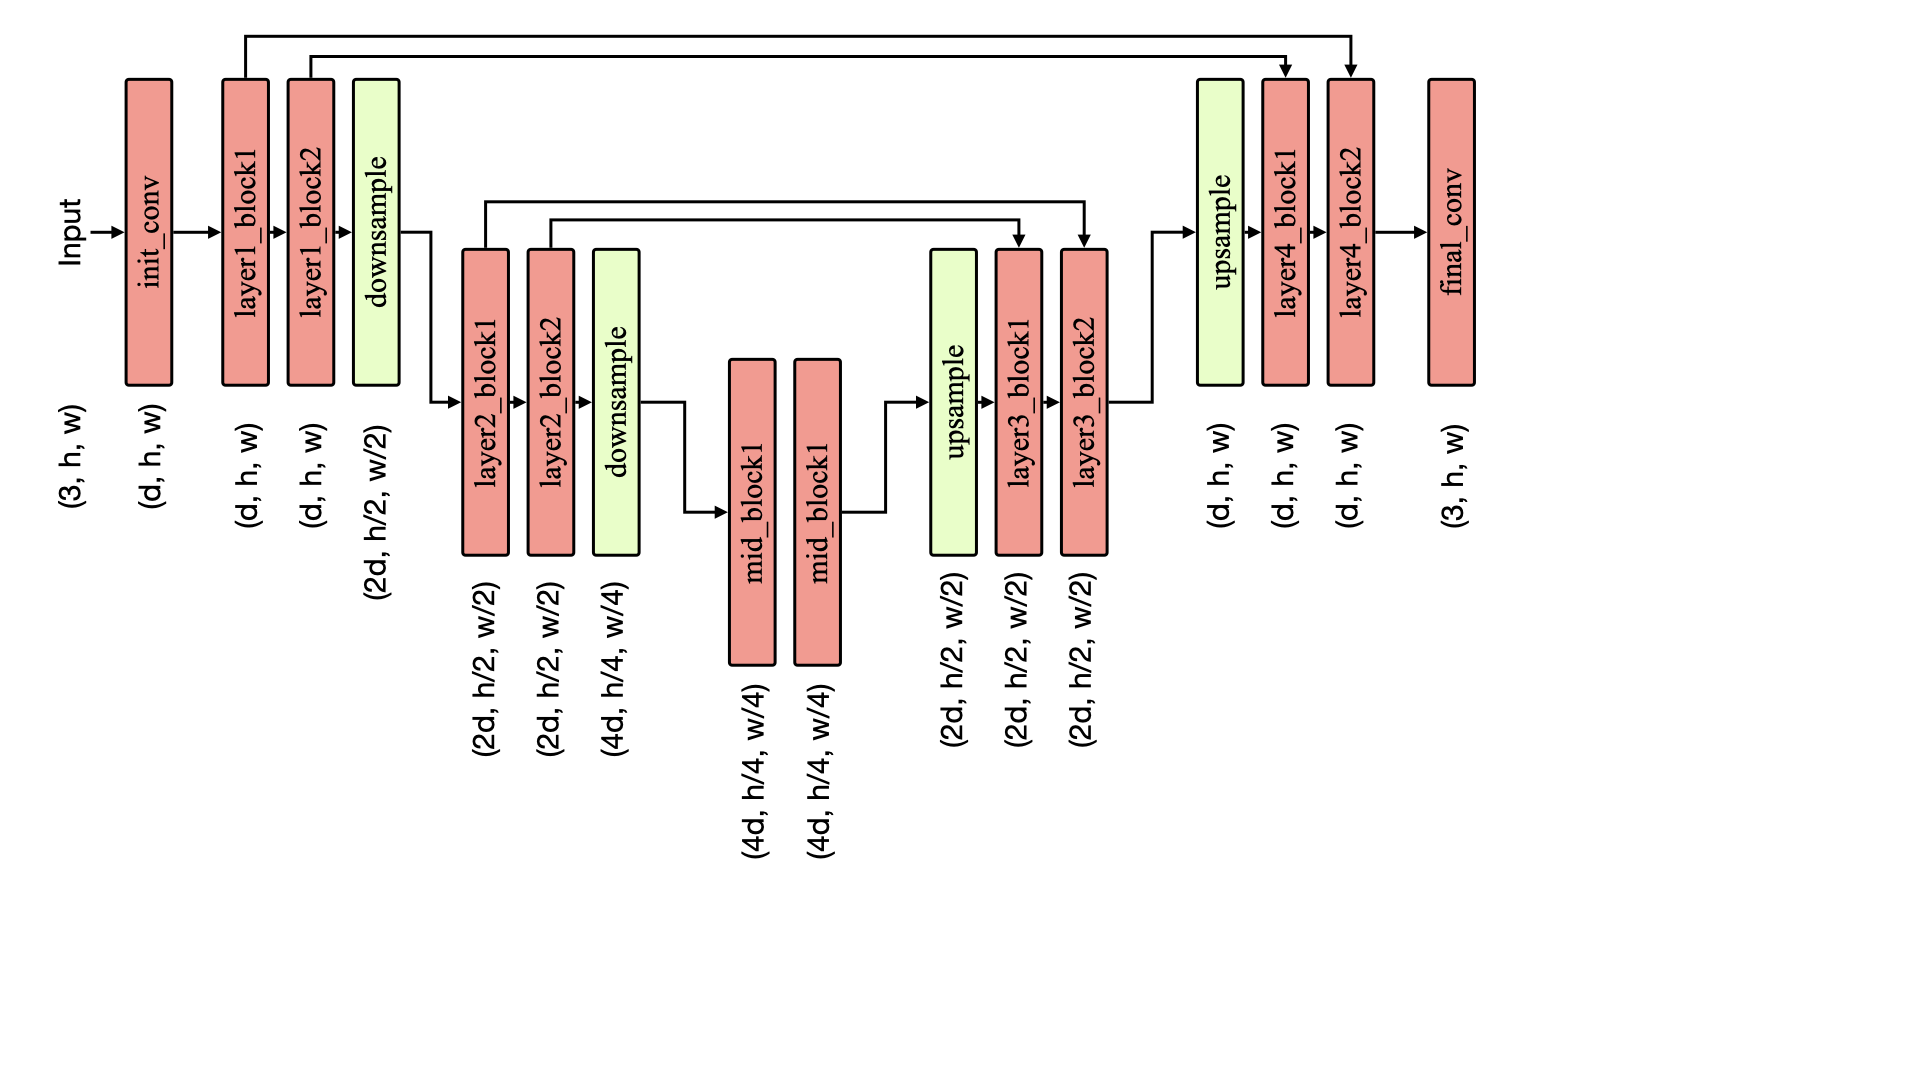

In [10]:
from IPython.display import Image
Image('./unet.png')

Implement the `Unet.__init__` method in `dl/unet.py` to define the upsampling and downsampling blocks of the UNet model, and then test it below. If your implementation is correct, you should not see any error. Calling `Unet(dim=d, condition_dim=condition_dim, dim_mults=(2,4))` should successfully create a UNet model corresponding to the architecture shown in the figure above.

In [ ]:
from dl.unet import Unet, ResnetBlock, Downsample, Upsample

dim = 2
condition_dim = 4
dim_mults = (1, 2, 4)
unet = Unet(dim=dim, condition_dim=condition_dim, dim_mults=dim_mults)


# Check number of layers
assert len(unet.downs) == len(dim_mults), "Number of Unet downsampling blocks is wrong."
assert len(unet.ups) == len(dim_mults), "Number of Unet upsampling blocks is wrong."


# Check layers
try:
  expected_downs_dims = [2, 2, 8, 2, 2, 8, 2, 2, 8, 2, 2, 8, 4, 4, 8, 4, 4, 8]
  downs_dims = [
      d for m in unet.downs for d in [
          m[0].dim, m[0].dim_out, m[0].context_dim, m[1].dim, m[1].dim_out, m[1].context_dim,
      ]
  ]
  assert downs_dims == expected_downs_dims, "Dimensions don't match"
except Exception as e:
  raise RuntimeError("Downsampling blocks wrongly configured") from e


try:
  expected_ups_dims = [8, 4, 8, 8, 4, 8, 4, 2, 8, 4, 2, 8, 4, 2, 8, 4, 2, 8]
  ups_dims = [
      d for m in unet.ups for d in [
          m[1].dim, m[1].dim_out, m[1].context_dim, m[2].dim, m[2].dim_out, m[2].context_dim,
      ]
  ]
  assert ups_dims == expected_ups_dims, "Dimensions don't match"
except Exception as e:
  raise RuntimeError("Upsampling blocks wrongly configured") from e

# Check number of parameters
num_params = sum(p.numel() for p in unet.parameters())
expected_num_params = 6499
assert num_params == expected_num_params, "Unet model creation is wrong!"

Fill in `Unet.forward` method in `dl/unet.py` and test it below. For now, don't worry about `Unet.cfg_forward` method. You should see relative error less than 1e-5.

In [ ]:
np.random.seed(231)
torch.manual_seed(231)

dim = 4
condition_dim = 4
dim_mults = (2, 4)
unet = Unet(dim=dim, condition_dim=condition_dim, dim_mults=dim_mults)

# For testing
force_deterministic_weights(unet)

b = 2
h = w = 4
inp_x = torch.randn(b, 3, h, w)
inp_text_emb = torch.randn(b, condition_dim)
inp_t = torch.tensor([8, 25]).long()
out = unet.forward(x=inp_x, time=inp_t,
                   model_kwargs={"text_emb": inp_text_emb}).detach().numpy()

expected_out = np.array(
      [[[[ 0.02593812,  0.02226132,  0.00880731,  0.00704543],
         [ 0.00079607,  0.00039904,  0.01747454,  0.02095483],
         [ 0.01897576,  0.01715839,  0.01896692,  0.01553369],
         [ 0.01399639,  0.01791124,  0.01262571,  0.00865982]],

        [[ 0.07770734,  0.07181297,  0.07872851,  0.08301098],
         [ 0.08354373,  0.09147768,  0.08321355,  0.08030565],
         [ 0.0780492 ,  0.0786341 ,  0.07829586,  0.07623564],
         [ 0.08295167,  0.0796023 ,  0.07909589,  0.0847287 ]],

        [[ 0.09379031,  0.10517272,  0.10958614,  0.10574961],
         [ 0.11130252,  0.10132759,  0.09505569,  0.09537686],
         [ 0.10030575,  0.10135849,  0.09999214,  0.10611867],
         [ 0.09887619,  0.09933992,  0.10528747,  0.10188967]]],


       [[[ 0.02549923,  0.02596914,  0.01346671,  0.00906688],
         [ 0.00719263,  0.0105091 ,  0.02457778,  0.02420544],
         [ 0.01462231,  0.01296406,  0.00115833, -0.00196741],
         [ 0.0189292 ,  0.02214047,  0.02487334,  0.01871004]],

        [[ 0.08039641,  0.07449423,  0.07858595,  0.08386144],
         [ 0.08179364,  0.08604097,  0.07780789,  0.07422686],
         [ 0.07966157,  0.07792775,  0.08123489,  0.08710551],
         [ 0.0823001 ,  0.08001801,  0.07614189,  0.07782535]],

        [[ 0.0907138 ,  0.09795973,  0.10511311,  0.10261636],
         [ 0.10719382,  0.09832487,  0.09501919,  0.10007297],
         [ 0.10255137,  0.10647621,  0.11395857,  0.10940972],
         [ 0.09479517,  0.09456725,  0.09690157,  0.10086412]]]])

print("forward error: ", rel_error(out, expected_out))

# p_losses

Now that we have model implementation done, let's write the DDPM's denoising training step. As mentioned before, optimizing the denoising loss is equivalent to minimizing the expected negative log likelihood of the dataset. Complete the `GaussianDiffusion.p_losses` method in `dl/gaussian_diffusion.py` and test it below. You should see relative error less than 1e-6 .

In [ ]:
np.random.seed(231)
torch.manual_seed(231)

dim = 4
condition_dim = 4
dim_mults = (2, 4)
unet = Unet(dim=dim, condition_dim=condition_dim, dim_mults=dim_mults)

# For testing
force_deterministic_weights(unet)

h = w = 4
b = 3
diffusion = GaussianDiffusion(
      model=unet,
      image_size=h,
      timesteps=1000,
      beta_schedule="sigmoid",
      objective="pred_x_start",
)

inp_x = torch.randn(b, 3, h, w)
inp_model_kwargs = {"text_emb": torch.randn(b, condition_dim)}
out = diffusion.p_losses(inp_x, inp_model_kwargs)

expected_out = 25.8341

print("forward error: ", rel_error(out.item(), expected_out))

## p_sample

There is one final ingredient remaining now. DDPM generates samples by iteratively performing the reverse process. Each iteration of this reverse process involves sampling from $p(x_{t-1}|x_t)$. Open `dl/gaussian_diffusion.py` and implement `p_sample` method by following Equation (6) from the paper. This equation describes sampling from the posterior of the forward process, conditioned on $x_t$ and $x_0$, where $x_0$ can be derived from the denoising model's output. We have already implemented `sample` method that iteratively calls `p_sample` to generate images from input texts.

Test your implementation of `p_sample` below, you should see relative errors less than 1e-6.

In [ ]:
np.random.seed(231)
torch.manual_seed(231)

dim = 4
condition_dim = 4
dim_mults = (2,)
unet = Unet(dim=dim, condition_dim=condition_dim, dim_mults=dim_mults)

# For testing
force_deterministic_weights(unet)

h = w = 4
b = 1
inp_x_t = torch.randn(b, 3, h, w)
inp_model_kwargs = {"text_emb": torch.randn(b, condition_dim)}
t = 231

# test 1
diffusion = GaussianDiffusion(
      model=unet,
      image_size=h,
      timesteps=1000,
      beta_schedule="sigmoid",
      objective="pred_x_start",
)
out = diffusion.p_sample(inp_x_t, t, inp_model_kwargs).detach().numpy()
expected_out = np.array(
    [[[[ 1.1008577 ,  0.13837332, -0.75881475,  1.3733847 ],
         [-0.19831228,  0.4733895 ,  1.0512062 , -0.78223056],
         [-0.26797467,  0.9668064 ,  0.06071047,  0.50392926],
         [-1.0048022 , -0.47658437, -0.07394935, -0.03371627]],

        [[ 0.07638204, -1.5470796 ,  0.3356028 , -0.7522933 ],
         [-1.0964824 , -1.7077568 ,  0.8525224 , -1.2582033 ],
         [-0.51024836,  1.0133357 ,  0.604344  , -0.41513133],
         [-0.2003653 ,  0.5475217 , -0.7513063 , -0.5189202 ]],

        [[ 0.8457652 ,  1.5340627 ,  2.0207863 ,  0.66845495],
         [ 0.20908687,  0.52820605, -0.7595484 ,  1.8309667 ],
         [ 0.6779673 ,  1.1924176 ,  1.8095882 , -1.5589235 ],
         [ 0.68622446, -0.8409808 ,  0.78457904,  0.13078652]]]])
print("forward error: ", rel_error(out, expected_out))

# test 2
diffusion = GaussianDiffusion(
      model=unet,
      image_size=h,
      timesteps=1000,
      beta_schedule="cosine",
      objective="pred_noise",
)
out = diffusion.p_sample(inp_x_t, t, inp_model_kwargs).detach().numpy()
expected_out = np.array(
    [[[[ 1.114109  ,  0.19495045, -0.6991788 ,  1.343692  ],
         [-0.21980241,  0.48805434,  1.0547467 , -0.7809341 ],
         [-0.2630887 ,  0.90634346,  0.0718035 ,  0.42476344],
         [-1.0138824 , -0.4929189 , -0.1298933 , -0.02763548]],

        [[ 0.09018886, -1.5867895 ,  0.43709922, -0.6014026 ],
         [-1.1252639 , -1.6531003 ,  0.80606025, -1.283144  ],
         [-0.5113594 ,  1.0397674 ,  0.71841675, -0.42914778],
         [-0.15277055,  0.55039245, -0.81665486, -0.48513824]],

        [[ 0.85230446,  1.6291221 ,  1.9445966 ,  0.5578472 ],
         [ 0.13313872,  0.6126938 , -0.82858956,  1.8336395 ],
         [ 0.69546056,  1.1269894 ,  1.8897432 , -1.5193422 ],
         [ 0.60326344, -0.86560655,  0.7667535 ,  0.1443256 ]]]])
print("forward error: ", rel_error(out, expected_out))

## Training

We have all ingredients needed for DDPM training and we can train the model on our Emoji dataset. You don't have to code anything here but we encourage you to look at the training code at `dl/ddpm_trainer.py`.

For the rest of the notebook, we will use a pretrained model from `dl/exp/pretrained` folder which is already trained for many iterations on this dataset. However, you are free to train your own model on colab GPU (make sure to change the `results_folder`). Note that it may take more than 12 hours on T4 GPU before you start seeing a reasonable generation.

In [ ]:
from dl.ddpm_trainer import Trainer

dim = 48
image_size = 32
results_folder = f"/content/drive/My Drive/{FOLDERNAME}dl/exp/pretrained"
condition_dim = 512

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Unet(
    dim=dim,
    dim_mults=(1, 2, 4, 8),
    condition_dim=condition_dim,
)
print("Number of parameters:", sum(p.numel() for p in model.parameters()))

diffusion = GaussianDiffusion(
    model,
    image_size=image_size,
    timesteps=100,  # number of diffusion steps
    objective="pred_noise",  # "pred_x_start" or "pred_noise"
)

dataset = EmojiDataset(image_size)

trainer = Trainer(
    diffusion,
    dataset,
    device,
    train_batch_size=256,
    weight_decay=0.0,
    train_lr=1e-3,
    train_num_steps=50000,
    results_folder=results_folder,
)

# You are not required to train it yourself.
# trainer.train()

In [ ]:
# Download and load the pretrained model.
trainer.download_pretrained()
trainer.load(70000)

In [ ]:
# Helper function to get CLIP text embedding during inference time.
from dl.emoji_dataset import ClipEmbed
clip_embedder = ClipEmbed(device)
def get_text_emb(text):
    return trainer.ds.embed_new_text(text, clip_embedder)

# Helper function to visualize generations.
def show_images(img):
    # img: B x T x 3 x H x W
    plt.figure(figsize=(10, 10))
    img2 = img.clamp(0, 1).permute(0, 3, 1, 4, 2).flatten(0, 1).flatten(1, 2).cpu().numpy()
    plt.imshow(img2)
    plt.axis('off')

    plt.show()

## Sampling

Run the cell below to visualize emoji generations conditioned on a text prompt. Feel free to modify the prompt to explore different generations. Since our emoji dataset is quite small, it is insufficient to train a fully generalizable text-to-image model. Because of that, generations for unseen prompts may be poor or may not be faithful to the input text (this may also happen for seen examples but less common).

For faster sampling, you may use a GPU runtime. If you switch the runtime type, be sure to rerun the entire notebook.

In [ ]:
# text = "crying face"  # seen example, good generations
text = "face with cowboy hat"  # seen example, good generations
# text = "crying face with cowboy hat"  # unseen example, bad generations
text_emb = get_text_emb(text)
text_emb = text_emb[None].expand(5, -1).to(device)


img = trainer.diffusion_model.sample(
    batch_size=5,
    model_kwargs={"text_emb": text_emb},
    return_all_timesteps=True
)
show_images(img[:, ::20])

## Classifier Free Guidance

Generative models are typically evaluated on fidelity (i.e., the quality or realism of the generated samples) and diversity (the variability or coverage of the sample space). For conditional generative models, fidelity additionally refers to how faithfully the generated samples adhere to the input conditions. These two metrics are often in tension with each other, leading to a trade-off between them. Ho et al. introduced a simple technique called classifier-free guidance [3], which allows explicit control over this trade-off.


In classifier-free guidance, during the training of a conditional diffusion model $\epsilon_\theta(x_t, t, c)$ , the condition $c$ is randomly dropped (i.e. replaced with $c=\phi$) with some probability (typically 0.1 to 0.2). During each denoising step of sampling, the prediction is updated as:
$$\epsilon_\theta(x_t, t, c) \leftarrow (w+1) \epsilon_\theta(x_t, t, c) - w \epsilon_\theta(x_t, t, \phi)$$
where $w$ is a positive scalar (the guidance scale). In other words, we perform two predictions during each denoising step, one conditional and one unconditional, and combine them linearly to favor the conditional generation. $w$ is a hyperparameter that is tuned to optimize a model-specific evaluation metric. A higher $w$ makes the generations more faithful to the condition but tends to reduce their diversity.

[3] Classifier-Free Diffusion Guidance. Jonathan Ho, Tim Salimans. [Link](https://arxiv.org/abs/2207.12598)

Implement the classifier-free guidance in `Unet.cfg_forward` method in `dl/unet.py` and test it below. You should see relative error less than 1e-6.

In [ ]:
np.random.seed(231)
torch.manual_seed(231)

dim = 4
condition_dim = 4
dim_mults = (2, 4)
unet = Unet(dim=dim, condition_dim=condition_dim, dim_mults=dim_mults)

# For testing
force_deterministic_weights(unet)

b = 2
h = w = 4
inp_x = torch.randn(b, 3, h, w)
inp_text_emb = torch.randn(b, condition_dim)
inp_t = torch.tensor([8, 25]).long()
out = unet.forward(x=inp_x, time=inp_t,
                   model_kwargs={"text_emb": inp_text_emb, "cfg_scale": 2.31}
                   ).detach().numpy()

expected_out = np.array(
      [[[[ 2.65555605e-02,  2.27778964e-02,  1.08210351e-02,
           8.84651206e-03],
         [-4.81749885e-05,  1.86618883e-04,  1.60563812e-02,
           1.96773224e-02],
         [ 1.94213986e-02,  1.73744597e-02,  1.87530853e-02,
           1.48321837e-02],
         [ 1.40390433e-02,  1.87087581e-02,  1.40099265e-02,
           1.05756857e-02]],

        [[ 7.76935965e-02,  7.20425993e-02,  7.95544237e-02,
           8.17399323e-02],
         [ 8.30703825e-02,  9.06537175e-02,  8.24938565e-02,
           8.10403079e-02],
         [ 7.81769305e-02,  7.89120197e-02,  7.78646469e-02,
           7.62439817e-02],
         [ 8.29512626e-02,  7.93126076e-02,  8.08649957e-02,
           8.46824944e-02]],

        [[ 9.31908041e-02,  1.04355931e-01,  1.06492668e-01,
           1.05610132e-01],
         [ 1.12765610e-01,  1.02617189e-01,  9.74146426e-02,
           9.56939906e-02],
         [ 9.96931046e-02,  1.00779071e-01,  1.00769714e-01,
           1.06809258e-01],
         [ 9.88340676e-02,  9.89211202e-02,  1.01590574e-01,
           1.00034207e-01]]],


       [[[ 2.56188512e-02,  2.55954899e-02,  1.36910230e-02,
           9.44550522e-03],
         [ 7.97471218e-03,  1.38147902e-02,  2.43024789e-02,
           2.19260491e-02],
         [ 1.37157515e-02,  1.08573250e-02,  1.49279367e-04,
          -1.05379149e-03],
         [ 1.98160559e-02,  2.44915597e-02,  2.57879905e-02,
           1.81518905e-02]],

        [[ 7.98096508e-02,  7.44081438e-02,  7.91016221e-02,
           8.40441585e-02],
         [ 8.29054862e-02,  8.70032459e-02,  7.48890638e-02,
           7.29139000e-02],
         [ 7.88886845e-02,  7.72688985e-02,  8.33076239e-02,
           8.86446685e-02],
         [ 8.29050690e-02,  8.10919553e-02,  7.49256462e-02,
           7.65042901e-02]],

        [[ 9.13612247e-02,  9.84459072e-02,  1.04214653e-01,
           1.01998910e-01],
         [ 1.04958251e-01,  9.37611908e-02,  9.91102159e-02,
           1.04068786e-01],
         [ 1.04468331e-01,  1.09444231e-01,  1.12257928e-01,
           1.06483996e-01],
         [ 9.31174308e-02,  9.08121765e-02,  9.75768715e-02,
           1.03149235e-01]]]])


print("forward error: ", rel_error(out, expected_out))

Run the cell below to visualize emoji generations using classifier-free guidance. Feel free to modify the "cfg_scale" parameter value as well. As mentioned earlier, since our model does not generalize well, you may or may not observe faithful generations even with a high guidance scale.



In [ ]:
# text = "crying face"  # seen example, good generations
text = "face with cowboy hat"  # seen example, good generations
# text = "crying face with cowboy hat"  # unseen example, bad generations
text_emb = get_text_emb(text)
text_emb = text_emb[None].expand(5, -1).to(device)


img = trainer.diffusion_model.sample(
    batch_size=5,
    model_kwargs={"text_emb": text_emb, "cfg_scale": 1},
    return_all_timesteps=True
)
show_images(img[:, ::20])